In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/unsw-nb15/NUSW-NB15_features.csv


In [11]:
import numpy as np
import pandas as pd

from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [12]:
df_train = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
df_train.info()
df_train.head(10)
df_train.describe(include='all')
list_drop = ['id','attack_cat']
df_train.drop(list_drop,axis=1,inplace=True)
# Clamp extreme Values
df_numeric = df_train.select_dtypes(include=[np.number])
df_numeric.describe(include='all')
DEBUG =0

for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('max = '+str(df_numeric[feature].max()))
        print('75th = '+str(df_numeric[feature].quantile(0.95)))
        print('median = '+str(df_numeric[feature].median()))
        print(df_numeric[feature].max()>10*df_numeric[feature].median())
        print('----------------------------------------------------')
    if df_numeric[feature].max()>10*df_numeric[feature].median() and df_numeric[feature].max()>10 :
        df_train[feature] = np.where(df_train[feature]<df_train[feature].quantile(0.95), df_train[feature], df_train[feature].quantile(0.95))
df_numeric = df_train.select_dtypes(include=[np.number])
df_numeric.describe(include='all')
df_numeric = df_train.select_dtypes(include=[np.number])
df_before = df_numeric.copy()
DEBUG = 0
for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_numeric[feature].nunique()))
        print(df_numeric[feature].nunique()>50)
        print('----------------------------------------------------')
    if df_numeric[feature].nunique()>50:
        if df_numeric[feature].min()==0:
            df_train[feature] = np.log(df_train[feature]+1)
        else:
            df_train[feature] = np.log(df_train[feature])

df_numeric = df_train.select_dtypes(include=[np.number])
df_cat = df_train.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')
DEBUG = 0
for feature in df_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_cat[feature].nunique()))
        print(df_cat[feature].nunique()>6)
        print(sum(df_train[feature].isin(df_train[feature].value_counts().head().index)))
        print('----------------------------------------------------')
    
    if df_cat[feature].nunique()>6:
        df_train[feature] = np.where(df_train[feature].isin(df_train[feature].value_counts().head().index), df_train[feature], '-')
df_cat = df_train.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

X = df_train.iloc[:,4:-2]
y = df_train.iloc[:,-1]
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,3])], remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 18:] = sc.fit_transform(X_train[:, 18:])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [13]:
df_test = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')
df_test.info()
df_test.head(10)
df_test.describe(include='all')
list_drop = ['id','attack_cat']
df_test.drop(list_drop,axis=1,inplace=True)
# Clamp extreme Values
df_numeric = df_test.select_dtypes(include=[np.number])
df_numeric.describe(include='all')
DEBUG =0

for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('max = '+str(df_numeric[feature].max()))
        print('75th = '+str(df_numeric[feature].quantile(0.95)))
        print('median = '+str(df_numeric[feature].median()))
        print(df_numeric[feature].max()>10*df_numeric[feature].median())
        print('----------------------------------------------------')
    if df_numeric[feature].max()>10*df_numeric[feature].median() and df_numeric[feature].max()>10 :
        df_test[feature] = np.where(df_test[feature]<df_test[feature].quantile(0.95), df_test[feature], df_test[feature].quantile(0.95))
df_numeric = df_test.select_dtypes(include=[np.number])
df_numeric.describe(include='all')
df_numeric = df_test.select_dtypes(include=[np.number])
df_before = df_numeric.copy()
DEBUG = 0
for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_numeric[feature].nunique()))
        print(df_numeric[feature].nunique()>50)
        print('----------------------------------------------------')
    if df_numeric[feature].nunique()>50:
        if df_numeric[feature].min()==0:
            df_test[feature] = np.log(df_test[feature]+1)
        else:
            df_test[feature] = np.log(df_test[feature])

df_numeric = df_test.select_dtypes(include=[np.number])
df_cat = df_test.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')
DEBUG = 0
for feature in df_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_cat[feature].nunique()))
        print(df_cat[feature].nunique()>6)
        print(sum(df_test[feature].isin(df_test[feature].value_counts().head().index)))
        print('----------------------------------------------------')
    
    if df_cat[feature].nunique()>6:
        df_test[feature] = np.where(df_test[feature].isin(df_test[feature].value_counts().head().index), df_test[feature], '-')
df_cat = df_test.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

X = df_test.iloc[:,4:-2]
y = df_test.iloc[:,-1]
fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(X.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1,2,3])], remainder='passthrough')
X_test = np.array(ct.fit_transform(X_test))
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_test[:, 18:] = sc.fit_transform(X_test[:, 18:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                82332 non-null  float64
 1   proto              82332 non-null  object 
 2   service            82332 non-null  object 
 3   state              82332 non-null  object 
 4   spkts              82332 non-null  float64
 5   dpkts              82332 non-null  float64
 6   sbytes             82332 non-null  float64
 7   dbytes             82332 non-null  float64
 8   rate               82332 non-null  float64
 9   sttl               82332 non-null  int64  
 10  dttl               82332 non-null  int64  
 11  sload              82332 non-null  float64
 12  dload              82332 non-null  float64
 13  sloss              82332 non-null  float64
 14  dloss              82332 non-null  float64
 15  sinpkt             82332 non-null  float64
 16  dinpkt             823

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix # will plot the confusion matrix
import time
model_performance = pd.DataFrame(columns=['Accuracy','Recall','Precision','F1-Score','time to train','time to predict','total time'])


In [16]:
%%time
from sklearn.linear_model import LogisticRegression
start = time.time()
model = LogisticRegression().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 4.39 s, sys: 1.94 s, total: 6.33 s
Wall time: 1.61 s


In [17]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)
f1s = f1_score(y_test, y_predictions)

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Logistic'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 44.85%
Recall: 26.44%
Precision: 77.99%
F1-Score: 39.49%
time to train: 1.59 s
time to predict: 0.02 s
total: 1.61 s


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     56000
           1       0.97      0.92      0.94    119341

    accuracy                           0.92    175341
   macro avg       0.90      0.92      0.91    175341
weighted avg       0.93      0.92      0.92    175341



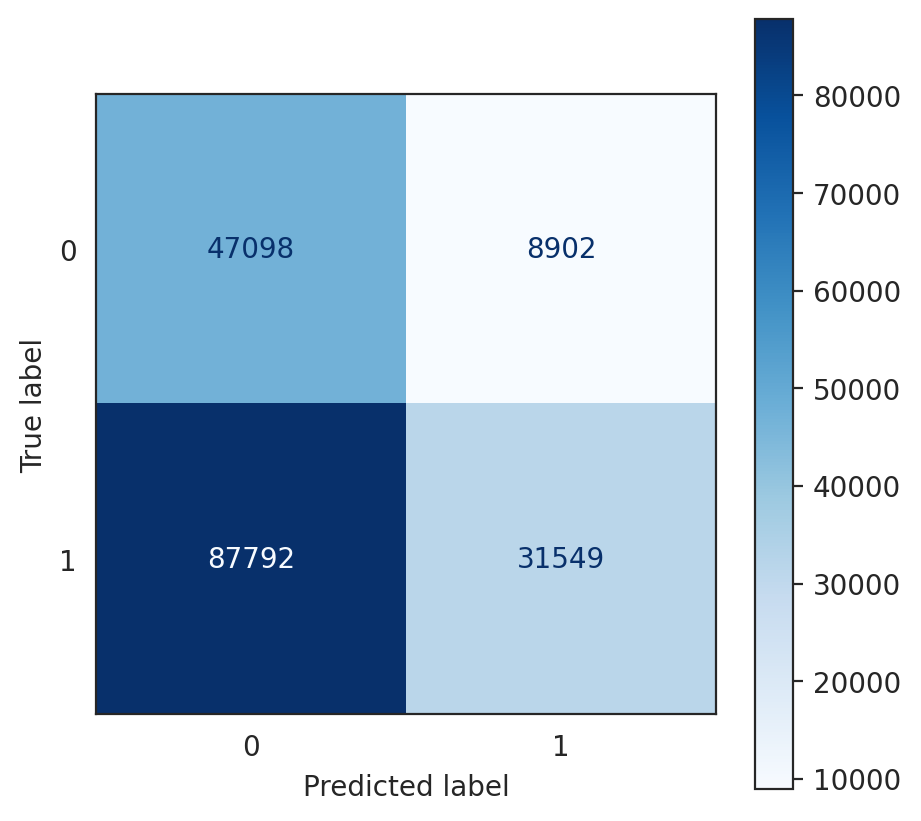

In [19]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [20]:
%%time
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
model = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 5min 40s, sys: 2min 38s, total: 8min 19s
Wall time: 5min


In [21]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)
f1s = f1_score(y_test, y_predictions)

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['KNN'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 88.36%
Recall: 85.12%
Precision: 97.45%
F1-Score: 90.87%
time to train: 0.01 s
time to predict: 300.65 s
total: 300.66 s


In [22]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84     56000
           1       0.97      0.85      0.91    119341

    accuracy                           0.88    175341
   macro avg       0.86      0.90      0.87    175341
weighted avg       0.90      0.88      0.89    175341



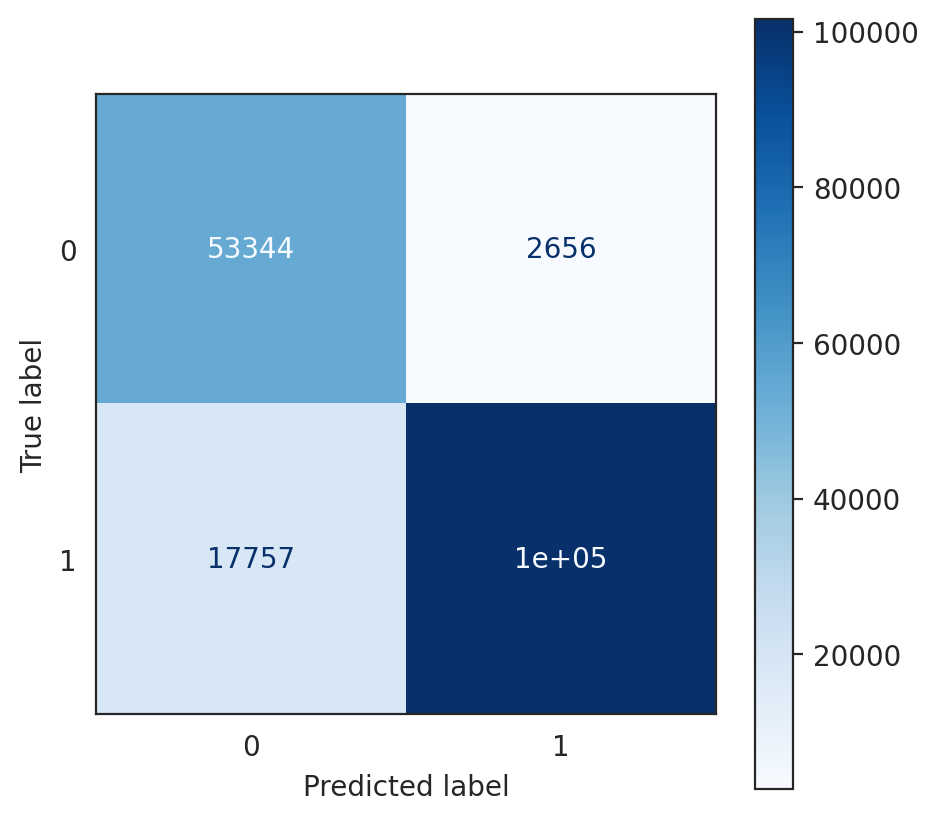

In [23]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [24]:
%%time
from sklearn.tree import DecisionTreeClassifier
start = time.time()
model = DecisionTreeClassifier().fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 1.59 s, sys: 25.1 ms, total: 1.62 s
Wall time: 1.64 s


In [25]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)
f1s = f1_score(y_test, y_predictions)

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Decision Tree'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 78.86%
Recall: 72.70%
Precision: 95.08%
F1-Score: 82.40%
time to train: 1.54 s
time to predict: 0.05 s
total: 1.59 s


In [26]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.61      0.92      0.74     56000
           1       0.95      0.73      0.82    119341

    accuracy                           0.79    175341
   macro avg       0.78      0.82      0.78    175341
weighted avg       0.84      0.79      0.80    175341



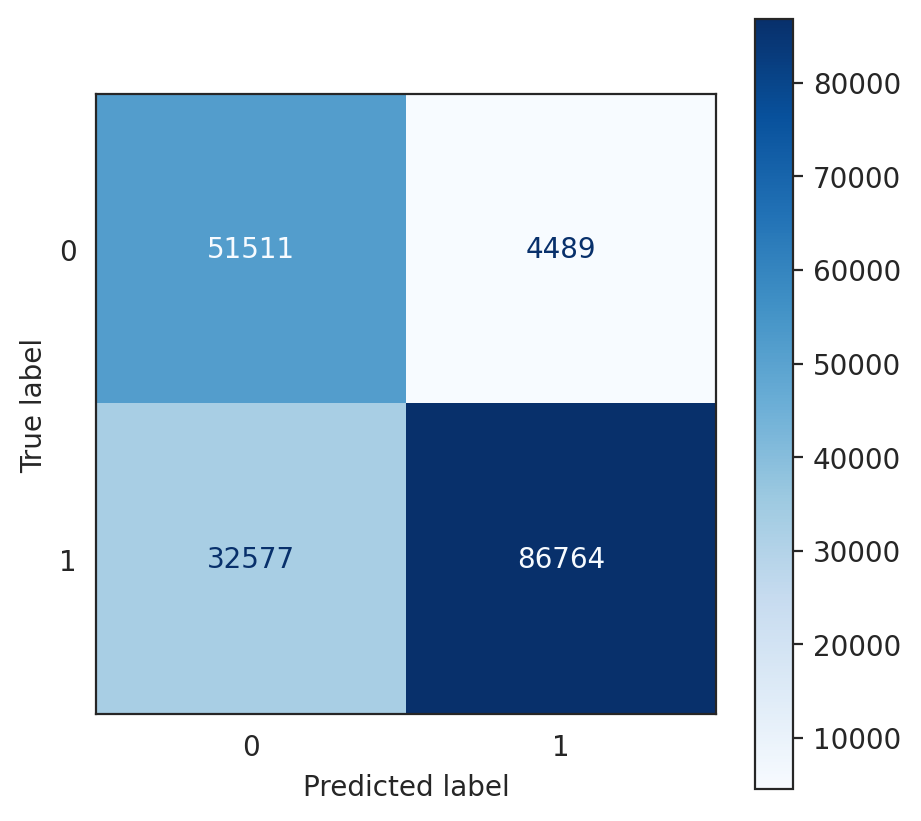

In [27]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [28]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
start = time.time()
model = ExtraTreesClassifier(random_state=0,n_jobs=-1).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 15.5 s, sys: 138 ms, total: 15.6 s
Wall time: 4.24 s


In [29]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)
f1s = f1_score(y_test, y_predictions)

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Extra Trees'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 93.07%
Recall: 97.09%
Precision: 93.03%
F1-Score: 95.01%
time to train: 3.47 s
time to predict: 0.64 s
total: 4.11 s


In [30]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.93      0.84      0.89     56000
           1       0.93      0.97      0.95    119341

    accuracy                           0.93    175341
   macro avg       0.93      0.91      0.92    175341
weighted avg       0.93      0.93      0.93    175341



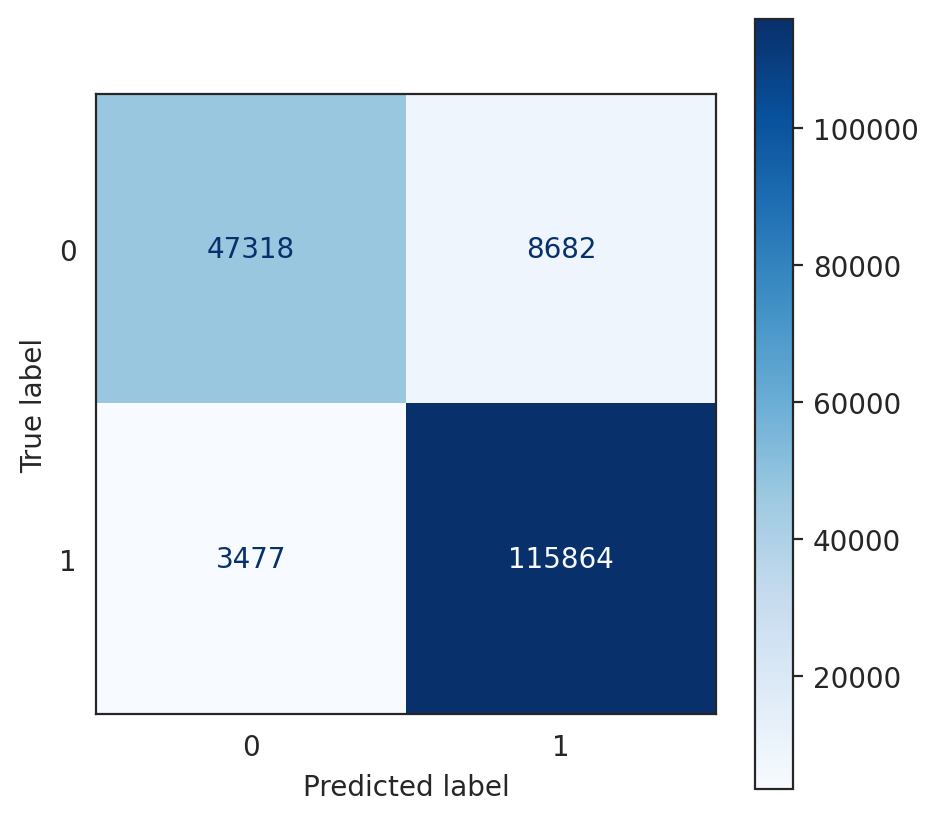

In [31]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [32]:
%%time
from sklearn.ensemble import RandomForestClassifier
start = time.time()
model = RandomForestClassifier(n_estimators = 100,n_jobs=-1,random_state=0,bootstrap=True,).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

CPU times: user 23.6 s, sys: 112 ms, total: 23.7 s
Wall time: 6.42 s


In [33]:
accuracy = accuracy_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)
f1s = f1_score(y_test, y_predictions)

print("Accuracy: "+ "{:.2%}".format(accuracy))
print("Recall: "+ "{:.2%}".format(recall))
print("Precision: "+ "{:.2%}".format(precision))
print("F1-Score: "+ "{:.2%}".format(f1s))
print("time to train: "+ "{:.2f}".format(end_train-start)+" s")
print("time to predict: "+"{:.2f}".format(end_predict-end_train)+" s")
print("total: "+"{:.2f}".format(end_predict-start)+" s")
model_performance.loc['Random Forest'] = [accuracy, recall, precision, f1s,end_train-start,end_predict-end_train,end_predict-start]

Accuracy: 92.13%
Recall: 91.75%
Precision: 96.51%
F1-Score: 94.07%
time to train: 5.68 s
time to predict: 0.74 s
total: 6.42 s


In [34]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     56000
           1       0.97      0.92      0.94    119341

    accuracy                           0.92    175341
   macro avg       0.90      0.92      0.91    175341
weighted avg       0.93      0.92      0.92    175341



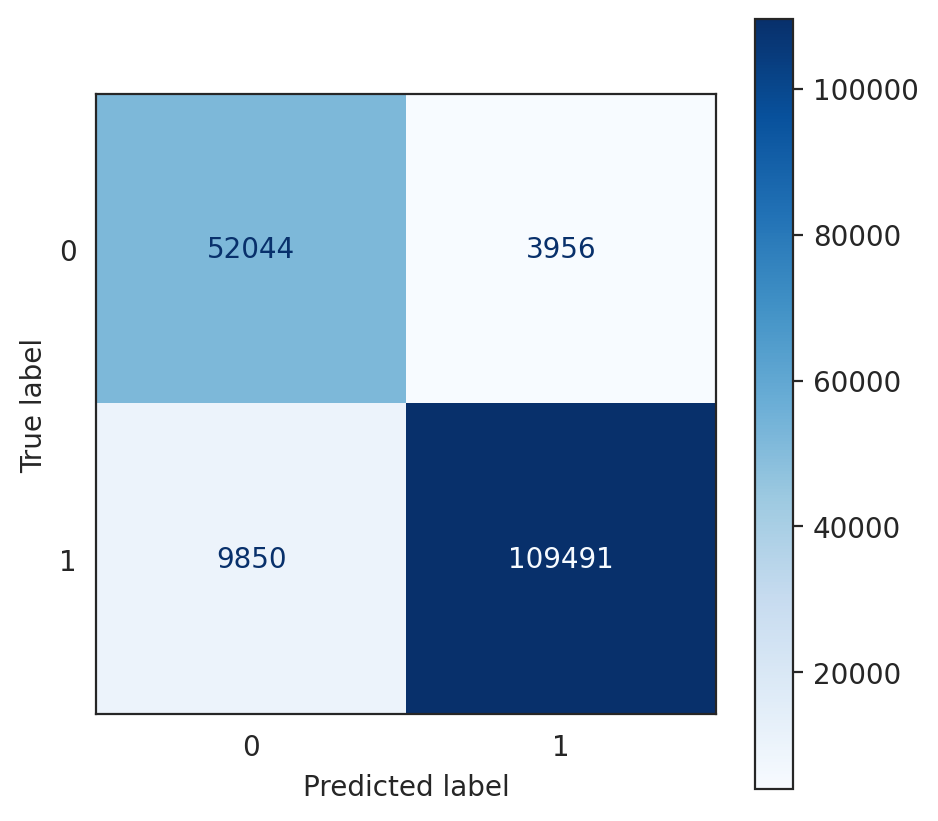

In [35]:
plt.rcParams['figure.figsize']=5,5 
sns.set_style("white")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()

In [36]:
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,time to train,time to predict,total time
Logistic,44.85%,26.44%,77.99%,39.49%,1.6,0.0,1.6
KNN,88.36%,85.12%,97.45%,90.87%,0.0,300.7,300.7
Decision Tree,78.86%,72.70%,95.08%,82.40%,1.5,0.1,1.6
Extra Trees,93.07%,97.09%,93.03%,95.01%,3.5,0.6,4.1
Random Forest,92.13%,91.75%,96.51%,94.07%,5.7,0.7,6.4


In [37]:
#Import libraries that will allow you to use keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from keras import metrics
!pip install keras-metrics #It doesn't come with Google Colab
import keras_metrics as km #when compiling
import keras
import numpy as np
from numpy import array

In [38]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [39]:
#Build the feed forward neural network model
def build_model():
    model = Sequential()
    model.add(Dense(20, input_dim=56, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='softmax')) #for multiclass classification
    #Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy',f1_m,precision_m, recall_m]
                 )
    return model

#institate the model
model = build_model()

#fit the model
start = time.time()
model.fit(X_train, y_train, epochs=200, batch_size=2000,verbose=2)
end_train = time.time()

Epoch 1/200
42/42 - 2s - loss: 2.5299 - accuracy: 0.2298 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - 2s/epoch - 46ms/step
Epoch 2/200
42/42 - 0s - loss: 0.9984 - accuracy: 0.7704 - f1_m: 0.4830 - precision_m: 0.6010 - recall_m: 0.4894 - 197ms/epoch - 5ms/step
Epoch 3/200
42/42 - 0s - loss: 0.4496 - accuracy: 0.8174 - f1_m: 0.6863 - precision_m: 0.5445 - recall_m: 0.9293 - 189ms/epoch - 5ms/step
Epoch 4/200
42/42 - 0s - loss: 0.3573 - accuracy: 0.8416 - f1_m: 0.7026 - precision_m: 0.5490 - recall_m: 0.9761 - 202ms/epoch - 5ms/step
Epoch 5/200
42/42 - 0s - loss: 0.3079 - accuracy: 0.8557 - f1_m: 0.7062 - precision_m: 0.5498 - recall_m: 0.9872 - 192ms/epoch - 5ms/step
Epoch 6/200
42/42 - 0s - loss: 0.2726 - accuracy: 0.8667 - f1_m: 0.7092 - precision_m: 0.5508 - recall_m: 0.9956 - 195ms/epoch - 5ms/step
Epoch 7/200
42/42 - 0s - loss: 0.2464 - accuracy: 0.8837 - f1_m: 0.7088 - precision_m: 0.5500 - recall_m: 0.9969 - 196ms/epoch - 5ms/step
Epoch 8/200
42/42 - 0s -

In [40]:
#Evaluate the neural network
loss, accuracy, f1s, precision, recall = model.evaluate(X_test, y_test)
end_predict = time.time()
model_performance.loc['MLP (Keras)'] = [accuracy, accuracy, accuracy, accuracy,end_train-start,end_predict-end_train,end_predict-start]

5480/5480 [==============================] - 10s 2ms/step - loss: 0.4942 - accuracy: 0.8776 - f1_m: 0.6968 - precision_m: 0.6807 - recall_m: 0.7268


In [41]:
#Build the neural network model
def build_model():
    model = Sequential()
    model.add(GRU(20, return_sequences=True,input_shape=(1,56)))
    model.add(GRU(20, return_sequences=True))
    model.add(Dense(10, activation='softmax')) #for multiclass classification
    #Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
                  # metrics=['accuracy',f1_m,precision_m, recall_m]
                  metrics=['accuracy']
                 )
    return model

#The GRU input layer must be 3D.
#The meaning of the 3 input dimensions are: samples, time steps, and features.
#reshape input data
X_train_array = array(X_train) #array has been declared in the previous cell
print(len(X_train_array))
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0],1,56)

#reshape output data
X_test_array=  array(X_test)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0],1,56) 


#institate the model
model = build_model()

start = time.time()
#fit the model
model.fit(X_train_reshaped, y_train, epochs=200, batch_size=2000,verbose=2)
end_train = time.time()

82332
Epoch 1/200
42/42 - 5s - loss: 1.9536 - accuracy: 0.6339 - 5s/epoch - 112ms/step
Epoch 2/200
42/42 - 1s - loss: 1.0941 - accuracy: 0.7487 - 508ms/epoch - 12ms/step
Epoch 3/200
42/42 - 1s - loss: 0.6206 - accuracy: 0.7579 - 509ms/epoch - 12ms/step
Epoch 4/200
42/42 - 0s - loss: 0.4703 - accuracy: 0.7827 - 498ms/epoch - 12ms/step
Epoch 5/200
42/42 - 1s - loss: 0.3810 - accuracy: 0.8255 - 537ms/epoch - 13ms/step
Epoch 6/200
42/42 - 1s - loss: 0.3117 - accuracy: 0.8616 - 513ms/epoch - 12ms/step
Epoch 7/200
42/42 - 1s - loss: 0.2609 - accuracy: 0.8848 - 514ms/epoch - 12ms/step
Epoch 8/200
42/42 - 1s - loss: 0.2296 - accuracy: 0.9022 - 521ms/epoch - 12ms/step
Epoch 9/200
42/42 - 1s - loss: 0.2097 - accuracy: 0.9112 - 509ms/epoch - 12ms/step
Epoch 10/200
42/42 - 1s - loss: 0.1956 - accuracy: 0.9179 - 512ms/epoch - 12ms/step
Epoch 11/200
42/42 - 1s - loss: 0.1839 - accuracy: 0.9241 - 514ms/epoch - 12ms/step
Epoch 12/200
42/42 - 1s - loss: 0.1746 - accuracy: 0.9286 - 523ms/epoch - 12ms/st

In [42]:
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
# loss, accuracy, f1s, precision, recall = model.evaluate(X_test_reshaped, y_test)
end_predict = time.time()
model_performance.loc['GRU (Keras)'] = [accuracy, accuracy, accuracy, accuracy, end_train-start,end_predict-end_train,end_predict-start]

5480/5480 [==============================] - 14s 2ms/step - loss: 0.5653 - accuracy: 0.8583


In [43]:
model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'time to train':'{:.2f}',
                                                                     'time to predict':'{:.2f}',
                                                                     'total time':'{:.2f}',
                                                                     })

,Accuracy,Recall,Precision,F1-Score,time to train,time to predict,total time
Logistic,44.85%,26.44%,77.99%,39.49%,1.59,0.02,1.61
KNN,88.36%,85.12%,97.45%,90.87%,0.01,300.65,300.66
Decision Tree,78.86%,72.70%,95.08%,82.40%,1.54,0.05,1.59
Extra Trees,93.07%,97.09%,93.03%,95.01%,3.47,0.64,4.11
Random Forest,92.13%,91.75%,96.51%,94.07%,5.68,0.74,6.42
MLP (Keras),87.76%,87.76%,87.76%,87.76%,41.17,9.84,51.00
GRU (Keras),85.83%,85.83%,85.83%,85.83%,145.63,21.34,166.97
